### Disciplina de Análise de Séries Temporais Não Lineares - UNIFESP
___

# Análise do preço do ouro em diferentes moedas

##### Autores: Aron Ifanger Maciel, Rodney Rick
___

### Resumo



In [29]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
gold_usd = pd.read_csv("golden_usd.csv")[280:]
bitcoin_usd = pd.read_csv("bitcoin_usd.csv")

In [4]:
gold_usd.set_index('date').plot(figsize=(18,5))

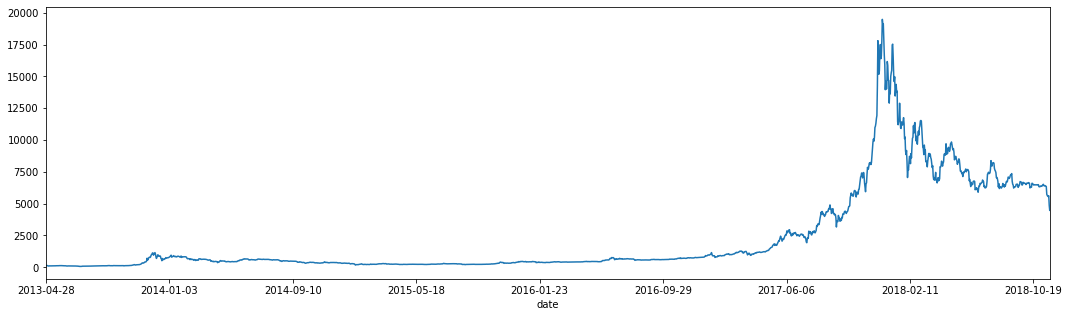

In [5]:
ft = bitcoin_usd['price(USD)'].notnull()
bitcoin_usd[ft].set_index('date')['price(USD)'].plot(figsize=(18,5))

O primeiro passo consiste na reconstrução do atrator. De acordo com o teorema de Takens, a informação completa sobre os estados ocultos de um sistema dinâmico pode ser presenrvada na série temporal. O espaço de fase é reconstruído a partir de versões 'atrasadas' (time-delayed versions) da série temporal como coordenadas do espaço. Ou seja, dada a série $x_n$, cada elemento $x_i$ da série é mapeado para o ponto $(x_{i−(m−1)\tau} , \dots , x_{i−\tau}, x_i)$ do espaço de dimensão $m$.

Para realizar a reconstrução do atrator é necessário conhecer previamente os parâmetros $m$ (dimensão do sistema) e $\tau$ (time-lag), o que não é óbvio. Existem métodos para estimar estes números, como o 'first minimum of the automutual information function', usado para estimação do time-lag e o 'Cao method' para a dimensão do sistema.

## Gráfico de recorrência

In [11]:
#import pylab as plt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import math

def rec_plot(s, eps=None, steps=None):
    
    """
    Função para plotar gráficos de recorrência
    """
    
    if eps==None: eps=0.01
    if steps==None: steps=10
    N = s.size
    S = np.repeat(s[None,:], N, axis=0)
    Z = np.floor(np.abs(S-S.T)/eps)
    Z[Z>steps] = steps
 
    return Z[::-1,:]

def plot_graph(s, f=rec_plot, eps=None, steps=None):
    fig = plt.figure(figsize=(8, 8)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.plot(s)
    ax2.imshow(f(s, eps=eps, steps=steps), cmap='gray')
    plt.show()

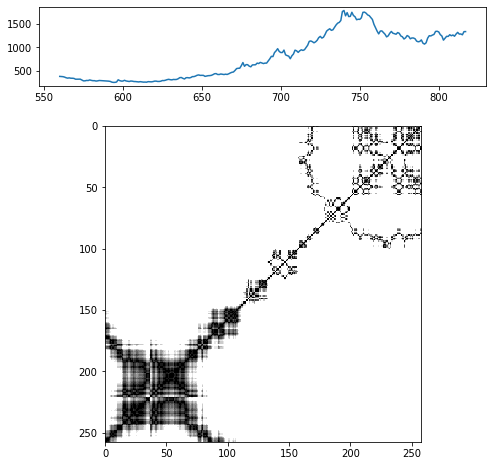

In [12]:
plot_graph(gold_usd.price[280:], eps=5)

In [13]:
def psr(serie, m=2, tau=2):
    """
    Phase Space Reconstruction from Taken's Theorem
    :param serie: original time serie
    :param m: embedding dimention;
    :param tau: lag;
    :return: lagged time serie.
    """
    tail_size = -(m-1)*tau
    if tail_size == 0:
        return np.array([np.roll(serie, -i*tau) for i in range(m)])
    else:
        return np.array([np.roll(serie, -i*tau)[:-(m-1)*tau] for i in range(m)])

def logdist(a,b):
    return math.log(abs(a - b) + 1e-6, 2)
    
def d(series,i,j):
    return abs(series[i]-series[j]) + 1e-6

def lyapunov_(serie,m=2,t=2):

    lagged_series=psr(serie,m,t)
    y=lagged_series[0]
    z=lagged_series[1]
    size=len(lagged_series[1])
    s=0
    k=10
    j=0
    while j<(size-k):
        L = logdist(y[j], z[j])
        L_linha = [logdist(y[j+inc], z[j+inc]) - L for inc in range(1,k)]
        s += np.mean(L_linha)
        j += k

    lyap=s/float(size)

    return  lyap

def lyapunov(series, eps=1):

    N=len(series)
    dlist=[[] for i in range(N)]
    n=0 #number of nearby pairs found
    for i in range(N):
        for j in range(i+1,N):
            if d(series,i,j) < eps:
                n+=1
                for k in range(min([N-i,N-j,10])):
                    dlist[k].append(math.log(d(series,i+k,j+k)))
    
    return(np.nanmean([np.nanmean(l) for l in dlist]))

In [17]:
np.roll(gold_usd.price[:100], 0)

array([101.623, 119.8  , 120.364, 106.225, 103.034,  99.923,  94.645,
       106.236, 129.027, 150.   , 168.298, 172.243, 163.568, 154.013,
       142.283, 154.362, 151.66 , 158.533, 181.483, 183.683, 176.864,
       179.553, 178.203, 170.066, 167.293, 164.25 , 164.867, 163.168,
       144.311, 142.691, 142.565, 139.279, 131.695, 130.94 , 132.676,
       127.91 , 126.913, 125.684, 117.866, 110.055, 114.098, 116.095,
       130.341, 133.674, 132.306, 136.163, 148.339, 149.184, 146.536,
       140.828, 143.383, 145.009, 149.334, 158.848, 162.132, 160.48 ,
       173.207, 178.36 , 183.771, 175.323, 176.19 , 183.761, 188.569,
       206.455, 212.212, 227.432, 207.082, 207.895, 226.986, 245.59 ,
       242.348, 239.174, 257.738, 279.36 , 295.009, 300.793, 354.498,
       390.959, 391.518, 463.666, 674.58 , 665.893, 554.276, 516.71 ,
       514.268, 600.786, 645.75 , 626.36 , 673.941, 662.27 , 623.875,
       596.712, 557.813, 500.8  , 499.693, 496.625, 480.316, 460.5  ,
       409.284, 410.

In [19]:
psr(np.arange(10),3,3)

array([[0, 1, 2, 3],
       [3, 4, 5, 6],
       [6, 7, 8, 9]])

In [20]:
def find_lag(serie, max_tau=1000, threshold=0.001, print_list=False):

    '''
    A common heuristic for selecting time lag is to use the first minimum of the automutual information function.
    :param serie: time serie
    :param max_tau: max iterations
    '''
    cf_first_min = 0
    tau_cf_first_min = 0

    for tau in range(max_tau):

        size = len(serie) - tau
        cf = np.mean([serie[t] * serie[t + tau] for t in range(0,size)]) /\
             np.mean([serie[t] ** 2 for t in range(0,size)])
                    
        if cf_first_min <= abs(cf) and cf * cf_first_min > 0:
            break
        
        cf_first_min = cf
        tau_cf_first_min = tau
        
    return tau_cf_first_min


def heaviside_step(v):
    ret=0
    if v>0 :
        ret=1

    return ret

def norm(a,b):
    s=0
    for i in range(len(a)):
        s+=(a[i]-b[i])**2

    return math.sqrt(s)

def correlation(series, r,n):
    s=len(series)
    somatorio=0
    for i in range(n):
        for j in range(n):
            ti=[]
            tj=[]
            for k in range(s):
                ti.append(series[k][i])
                tj.append(series[k][j])
            # print("ti",ti)
            # print("tj",tj)

            somatorio+=heaviside_step(r-norm(ti,tj))

    c=(2/float((n*(n-1))))+somatorio
    return c;

def is_like(a,b,limiar=0.5):
    k=abs(a-b)
    # print("k",k)
    # print("limiar",limiar)

    return k<=abs(limiar)

def find_saturation(m_list,v_list):
    v_list_len=len(v_list)
    m_list_len=len(m_list)

    if v_list_len!=m_list_len:
        raise ValueError("listas de tamanhos diferentes")

    if v_list_len<2:
        raise ValueError("lista menor menor que 2 ")

    # print("m_list",m_list)
    # print("v_list",v_list)

    m=None
    v_old=v_list[0]

    for i,v in enumerate(v_list[1:]):

        if is_like(v,v_old,v/100.0):
            m=m_list[max(0,i-1)]

            break
        v_old=v_list[i]

    return m


def calc_attractor_dimension(serie, dim_min=1, dim_max=20):
    """
    Baseado no Grassberger-Procaccia Algorithm
    :param serie: uma serie temporal
    :returns: um float com a dimensão encontrada. Ou "-1" caso não encontre 
    """
    m=dim_min
    limiar=0.5
    alpha=1
    tau=1
    is_attractor=False
    n=10
    v_list=[]
    m_list=list(range(1,dim_max+1))
    r=np.std(serie[:n])

    # print("r",r)
    for m in m_list:
        lagged_series=psr(serie,m,tau)
        c=correlation(lagged_series, r,n)
        v_list.append(math.log10(c)/math.log10(r))

    return find_saturation(m_list, v_list) 

In [21]:
tau = find_lag(gold_usd.price.values)
m = calc_attractor_dimension(gold_usd.price.values)

psr(gold_usd.price.values, m, tau)

array([[ 101.623,  119.8  ,  120.364, ..., 1265.674, 1332.809, 1333.775],
       [ 101.623,  119.8  ,  120.364, ..., 1265.674, 1332.809, 1333.775],
       [ 101.623,  119.8  ,  120.364, ..., 1265.674, 1332.809, 1333.775],
       [ 101.623,  119.8  ,  120.364, ..., 1265.674, 1332.809, 1333.775],
       [ 101.623,  119.8  ,  120.364, ..., 1265.674, 1332.809, 1333.775],
       [ 101.623,  119.8  ,  120.364, ..., 1265.674, 1332.809, 1333.775]])

In [23]:
#gold_usd['lyapunov30'] = gold_usd.price.rolling(30).agg(lyapunov)
gold_usd['lyapunov50'] = gold_usd.price.rolling(50).agg(lyapunov_)
#gold_usd['lyapunov100'] = gold_usd.price.rolling(100).agg(lyapunov)

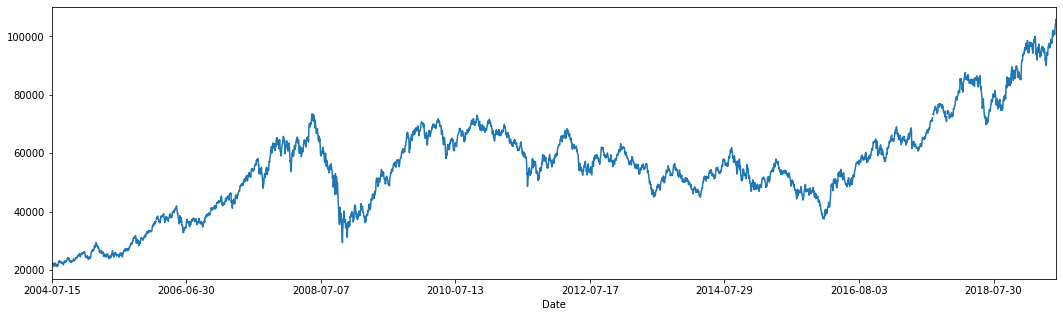

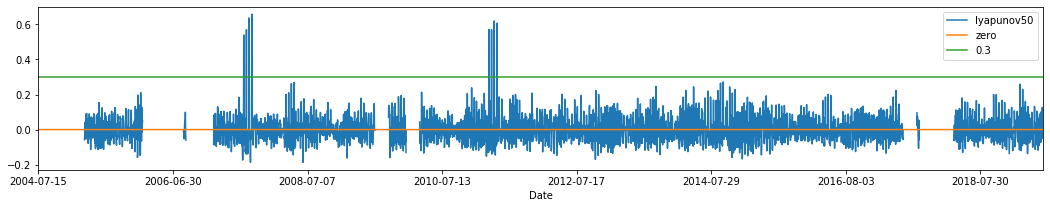

In [24]:
serie = pd.read_csv("bvsp.csv")
serie.set_index('Date')['Open'].plot(figsize=(18,5))
serie['zero'] = 0
serie['0.3'] = 0.3
serie['lyapunov50'] = serie.Open.rolling(50).agg(lyapunov_)
serie.set_index('Date')[['lyapunov50', 'zero', '0.3']].plot(figsize=(18,3))

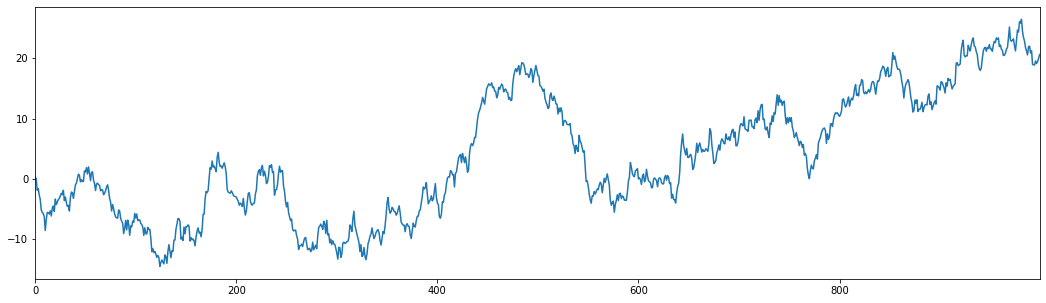

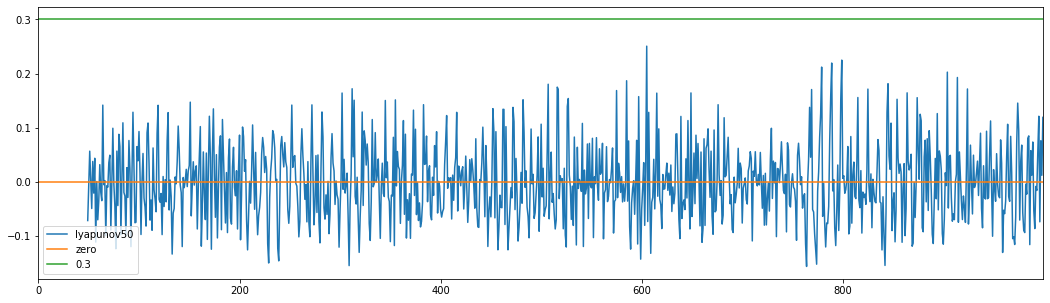

In [25]:
serie = pd.DataFrame({'value':np.random.normal(0,1,1000).cumsum()})
serie['value'].plot(figsize=(18,5))
serie['lyapunov50'] = serie.value.rolling(50).agg(lyapunov_)
serie['zero'] = 0
serie['0.3'] = 0.3
serie[['lyapunov50', 'zero', '0.3']].plot(figsize=(18,5))

In [35]:
import nolds

In [38]:
nolds.lyap_e(gold_usd.price, emb_dim=3, matrix_dim=3)

array([ 0.37791288, -0.09978332, -0.7097732 ], dtype=float32)

In [39]:
def generate(data_length, odes, state, parameters):
    data = np.zeros([state.shape[0], data_length])

    for i in range(5000):
        state = rk4(odes, state, parameters)

    for i in range(data_length):
        state = rk4(odes, state, parameters)
        data[:, i] = state

    return data


def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def lorenz_odes(state, parameters):
    x,y,z=state
    sigma, beta, rho=parameters
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def lorenz_generate(data_length):
    return generate(data_length, lorenz_odes, \
        np.array([-8.0, 8.0, 27.0]), np.array([10.0, 8/3.0, 28.0]))

In [40]:
nolds.lyap_e(lorenz_generate(1000)[2], emb_dim=3, matrix_dim=3, tau=3)

array([ 0.00531328, -0.00290154, -0.13226739], dtype=float32)

In [41]:
bovespa = pd.read_csv("bvsp.csv").set_index("Date")
bovespa = bovespa[bovespa.Open.notnull()]

In [42]:
tau = find_lag(bovespa.Open.values)
m = calc_attractor_dimension(bovespa.Open.values)

print(tau, m)

0 4


In [43]:
bovespa["lyapunov50"] = bovespa.Open.rolling(50).agg(lambda x: nolds.lyap_r(x, emb_dim=1, tau=1))

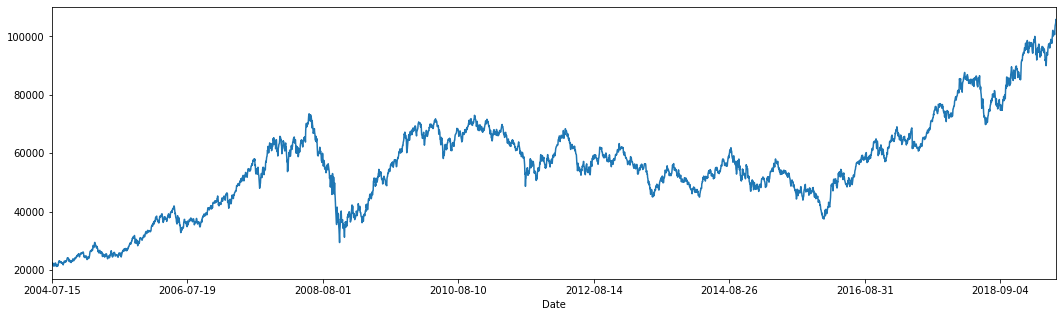

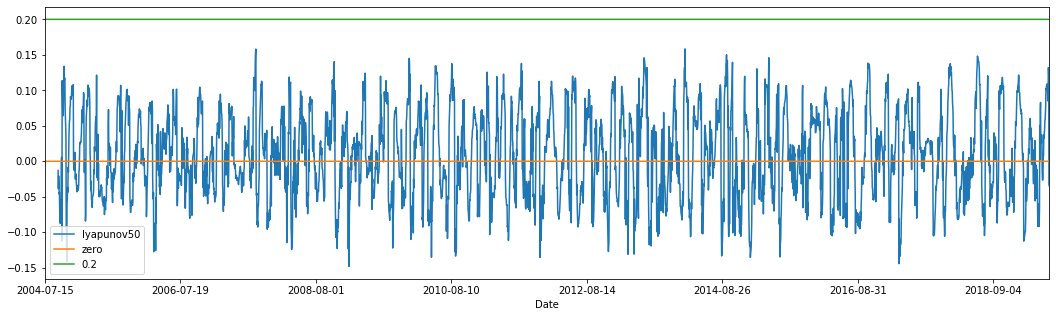

In [44]:
bovespa.Open.plot(figsize=(18,5))
bovespa['zero'] = 0
bovespa['0.2'] = 0.2
bovespa[['lyapunov50', 'zero', '0.2']].plot(figsize=(18,5))